# Qcodes example with Keysight B1500 Semiconductor Parameter Analyzer

## Instrument Short info
Here a short introduction on how the B1500 measurement system is composed is given. For a detailed overview it is strongly recommended to refer to the *B1500 Programming Guide* and also the *Parametric Measurement Handbook* by Keysight.

### Physical grouping
The Keysight B1500 Semiconductor Parameter Analyzer consists of a *Mainframe* and can be equipped with various instrument *Modules*. 10 *Slots* are available in which up to 10 *modules* can be installed (some *modules* occupy two *slots*). Each *module* can have one or two *channels*.

### Logical grouping
The measurements are typically done in one of the 20 measurement modes. The modes can be roughly subdivided into 
  - Spot measurements
      - **High Speed Spot Measurements**
  - Pulsed Spot measurement
  - Sweep Measurements
  - Search Measurements

The **High Speed Spot (HSS)** Mode is essentually just a fancy way of saying to take readings and forcing constant voltages/currents. The *HSS* commands work at any time, independent of the currenttly selected Measurment Mode.

With the exception of the *High Speed Spot Measurement Mode*, the other modes have to be activated and configured by the user.

## Qcodes driver info
As can be seen already from the instrument short info, the instrument is very versatile, but also very complex. Hence the driver will eventually consist of two layers:
  - The Low Level interface allows one to utilize all functions of the driver by offering a thin wrapper around the FLEX command set that the B1500 understands. 
  - A Higher Level interface that provides a convenient access to the more frequently used features. Not all features are available via the high level interface.

The two driver levels can be used at the same time, so even if some functionality is not yet implemented in the high-level interface, the user can send a corresponding low-level command.

### Integer Flags and Constants used in the driver
Both the high-level and the low-level interface use integer constants in many commands. For user convienience, the `qcodes.instrument_drivers.Keysight.keysightb1500.constants` provides more descriptive Python Enums for these constants. Although bare integer values can still be used, it is highly recommended to use the enumerations in order to avoid mistakes.

### High level interface
The high level exposes instrument functionality via QCodes Parameters and Python methods on the mainframe object and the individual instrument module objects. For example, *High Speed Spot* Measurement commands for forcing constant voltages/currents or for taking simple readings are implemented.

### Low level interface
The Low Level interface (`MessageBuilder` class) provides a wrapper function for each FLEX command. From the low-level, the full functionality of the instrument can be controlled.

The `MessageBuilder` assembles a message string which later can be sent to the instrument using the low level `write` and `ask` methods. One can also use the `MessageBuilder` to write FLEX complex measurement routines that are stored in the B1500 and can be executed at a later point. This can be done to enable fast execution.

## Programming Examples

### Initializing the instrument

In [31]:
from matplotlib import pyplot as plt
import qcodes as qc

from qcodes.instrument_drivers.Keysight.keysightb1500 import KeysightB1500, \
    MessageBuilder, constants
from pyvisa.errors import VisaIOError


from IPython.display import display, Markdown

In [2]:
station = qc.Station() # Create a station to hold all the instruments

In [3]:
# Note: If there is no physical instrument connected 
# the following code will try to load a simulated instrument

try:
    #TODO change that address according to your setup
    b1500 = KeysightB1500('SPA',
                          address='TCPIP::192.168.111.100::gpib0,22::INSTR')
    display(Markdown("**Note: using physical instrument.**"))
except (ValueError, VisaIOError):
    # Either there is no VISA lib installed or there was no real instrument found at the
    # specified address => use simulated instrument
    import qcodes.instrument.sims as sims
    path_to_yaml = sims.__file__.replace('__init__.py',
                                         'keysight_b1500.yaml')

    b1500 = KeysightB1500('SPA',
                          address='GPIB::1::INSTR',
                          visalib=path_to_yaml + '@sim')
    display(Markdown("**Note: using simulated instrument. Functionality will be limited.**"))

**Note: using simulated instrument. Functionality will be limited.**

In [4]:
station.add_component(b1500)

[SPA_smu1(B1517A)] Snapshot: Could not update parameter: time_axis
[SPA_smu2(B1517A)] Snapshot: Could not update parameter: time_axis


'SPA'

## High Level Interface

Here is an example of using the high-level interface.

### Identifying and selecting installed modules
As mentioned above, the B1500 is a modular instrument, and contains multiple cards. When initializing the driver, the driver requests the installed modules from the B1500 and exposes them to the user via multiple ways.

The first way to address a certain module is e.g. as follows:

In [5]:
b1500.smu1 # first SMU in the system
b1500.cmu1 # first CMU in the system
b1500.smu2 # second SMU in the system

<B1517A: SPA_smu2 of KeysightB1500: SPA>

The naming scheme is - `b1500.<instrument class as lower case><number>`, where number is `1` for the first instrument in its class, `2` for the second instrument in its class and so on. (*Not the channel or slot number!*)

Next to this direct access - which is simple and good for direct user interaction - the modules are also exposed via multiple data structures through which they can be adressed:
  - by slot number
  - by module kind (such as SMU, or CMU)
  - by channel number

This can be more convenient for programmatic selection of the modules.

Instrument modules are installed in slots (numbered 1-11) and can be selected by the slot number:

In [6]:
b1500.by_slot

{<SlotNr.SLOT01: 1>: <B1517A: SPA_smu1 of KeysightB1500: SPA>,
 <SlotNr.SLOT02: 2>: <B1517A: SPA_smu2 of KeysightB1500: SPA>,
 <SlotNr.SLOT03: 3>: <B1520A: SPA_cmu1 of KeysightB1500: SPA>,
 <SlotNr.SLOT06: 6>: <B1530A: SPA_wgfmu1 of KeysightB1500: SPA>}

All modules are also grouped by module kind (see `constants.ModuleKind` for list of known kinds of modules):

In [7]:
b1500.by_kind

defaultdict(list,
            {<ModuleKind.SMU: 'SMU'>: [<B1517A: SPA_smu1 of KeysightB1500: SPA>,
              <B1517A: SPA_smu2 of KeysightB1500: SPA>],
             <ModuleKind.CMU: 'CMU'>: [<B1520A: SPA_cmu1 of KeysightB1500: SPA>],
             <ModuleKind.WGFMU: 'WGFMU'>: [<B1530A: SPA_wgfmu1 of KeysightB1500: SPA>]})

For example, let's list all SMU modules:

In [8]:
b1500.by_kind['SMU']

[<B1517A: SPA_smu1 of KeysightB1500: SPA>,
 <B1517A: SPA_smu2 of KeysightB1500: SPA>]

Lastly, there is dictionary of all module channels:

In [9]:
# For the simulation driver:
# Note how the B1530A module has two channels.
# The first channel number is the same as the slot number (6).
# The second channel has a `02` appended to the channel number.
b1500.by_channel

{<ChNr.SLOT_01_CH1: 1>: <B1517A: SPA_smu1 of KeysightB1500: SPA>,
 <ChNr.SLOT_02_CH1: 2>: <B1517A: SPA_smu2 of KeysightB1500: SPA>,
 <ChNr.SLOT_03_CH1: 3>: <B1520A: SPA_cmu1 of KeysightB1500: SPA>,
 <ChNr.SLOT_06_CH1: 6>: <B1530A: SPA_wgfmu1 of KeysightB1500: SPA>,
 <ChNr.SLOT_06_CH2: 602>: <B1530A: SPA_wgfmu1 of KeysightB1500: SPA>}

**Note: For instruments with only one channel, channel number is the same as the slot number. However there are instruments with 2 channels per card. For these instruments the second channel number will differ from the slot number.**

**Note for the simulated instrument: The simulation driver will list a B1530A module with 2 channels as example.**

In general, the slot- and channel numbers can be passed as integers. However (especially in the case of the channel numbers for multi-channel instruments) it is recommended to use the Python enums defined in `qcodes.instrument_drivers.Keysight.keysightb1500.constants`:

In [10]:
# Selecting a module by channel number using the Enum
m1 = b1500.by_channel[constants.ChNr.SLOT_01_CH1]

# Without enum
m2 = b1500.by_channel[1]

# And we assert that we selected the same module:
assert m1 is m2

### Enabling / Disabling channels

Before sourcing or doing a measurement, the respective channel has to be enabled. There are two ways to enable/disable a channel:
  - By directly addressing the module
  - By addressing the mainframe and specifying which channel(s) to be enabled

The second method is useful if multiple channels shall be enabled, or for programmatic en-/disabling of channels. It also allows to en-/disable all channels with one call.

In [11]:
# Direct addressing the module
b1500.smu1.enable_outputs()
b1500.smu1.disable_outputs()

In [12]:
# Enabling via the mainframe

# enable one channel
b1500.enable_channels([1])

# enable multiple channels
b1500.enable_channels([1, 2])

# disable multiple channels
b1500.disable_channels([1, 2]) 

# disable all channels
b1500.disable_channels()

### Performing sampling measurements

This section outlines steps to perform sampling measurement. 

Connect to the instrument. 

In [5]:
spa = KeysightB1500('spa', address='GPIB21::17::INSTR')
spa.connect_message()

Connected to: Agilent Technologies B1500A (serial:0, firmware:A.06.01.2016.0401) in 0.35s


Set a sample rate and number of samples. 

In [8]:
# Number of spot measurments made per second and stored in a buffer. 
sample_rate = 0.02
# Total number of spot measurements. 
nsamples = 100

Assign timing parameters to SMU. 

In [9]:
spa.smu1.timing_parameters(0, sample_rate, nsamples)

Autozero is generally disabled for sampling measurement. 

In [10]:
spa.autozero_enabled(False)

Set SMU to sampling mode. 

In [11]:
spa.smu1.measurement_mode(constants.MM.Mode.SAMPLING)

SMU is configured with by assigning voltage output range, input output range and compliance. While forcing voltage, current should be the compliance and vice versa.


In [13]:
spa.smu1.source_config(output_range=constants.VOutputRange.AUTO,
                       compliance=1e-7, 
                       compl_polarity=None, 
                       min_compliance_range=constants.IOutputRange.AUTO
                      )
#spa.smu1.source_config(constants.VOutputRange.AUTO, 1e-7, None, constants.IOutputRange.AUTO)

Set SMU voltage

In [14]:
spa.smu1.voltage(1e-6)

Read the sampling measurement data from the buffer, parse it correctly and return it. 

In [17]:
data_sampling = spa.smu1.sampling_measurement.get()

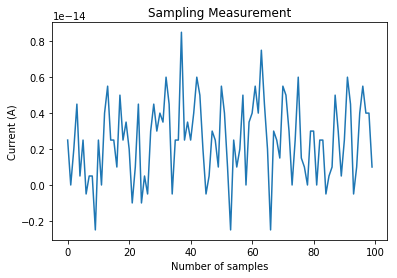

In [44]:
_ = plt.plot(data_sampling)
_ = plt.xlabel('Number of samples')
_ = plt.ylabel('Current (A)')
_ = plt.title('Sampling Measurement')

Check compliance: For the values which are compliant the output is one and for others it is zero. A quick to visualize of your measurements are compliant is to plot the compliance data and look if any value of zero.

In [29]:
data_compliance = spa.smu1.sampling_measurement.compliance()

All measurements are normal


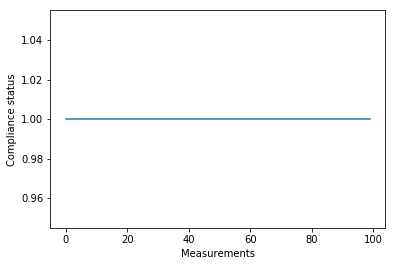

In [45]:
_ = plt.plot(data_compliance)
_ = plt.xlabel('Measurements')
_ = plt.ylabel('Compliance status')

``Troubleshooting commands`` In case you would like to have information about the channel number, type of data and type of compliance error you may look at the output of the following commands too.

In [23]:
data_status = spa.smu1.sampling_measurement.data.status
data_channel = spa.smu1.sampling_measurement.data.channel
data_type = spa.smu1.sampling_measurement.data.type

### SMU sourcing and measuring
The simplest measurement one can do with the B1500 are *High Speed Spot Measurements*. They work independent of the selected *Measurement Mode*.

The `voltage` and `current` Qcodes Parameters that the SMU High Level driver exposes will execute *High Speed Spot* measurements. Additionally, there are functions that let the user specify the output/measure ranges, and compliance limits.

To source a voltage/current do the following:
  1. Configure source range, and (optionally) compliance settings
  2. Enable the channel
  3. Force the desired voltage
  4. (optionally) Disable the channel

**Note: The source settings (Step 1) are persistent until changed again. So for sucessive measurements the configuration can be omitted.**

In [13]:
b1500.smu1.enable_outputs()

b1500.smu1.source_config(output_range=constants.VOutputRange.AUTO,
                         compliance=0.1)

b1500.smu1.voltage(1.5)

To measure do the following:
  1. Configure the measure range
  2. Enable the channel (if not yet enabled)
  3. Do the measurement
  4. (optionally) Disable the channel

**Note: The measure settings (Step 1) are persistent until changed again. So for sucessive measurements the configuration can be omitted.**

In [14]:
b1500.smu1.measure_config(measure_range=constants.IMeasRange.FIX_100uA)

b1500.smu1.enable_outputs()

cur = b1500.smu1.current()

b1500.smu1.disable_outputs()

### Setting up ADCs to NPLC mode

Both the mainframe driver and SMU driver implement convenience methods for controlling integration time of the *High Speed Spot* measurement, which allow setting ADC type, and setting the frequenty used NPLC mode.

Use the following methods on the mainframe instance to set up the ADCs to NPLC mode:

In [15]:
# Set the high-speed ADC to NPLC mode,
# and optionally specify the number of PLCs as an arugment
# (refer to the docstring and the user manual for more information)
b1500.use_nplc_for_high_speed_adc(n=1)

# Set the high-resolution ADC to NPLC mode,
# and optionally specify the number of PLCs as an arugment
# (refer to the docstring and the user manual for more information)
b1500.use_nplc_for_high_resolution_adc(n=5)

And then use the following methods on the SMU instances to use particular ADC for the particular SMU:

In [16]:
# Use high-speed ADC 
# with the settings defined above
# for the SMU 1
b1500.smu1.use_high_speed_adc()

# Use high-resoultion ADC 
# with the settings defined above
# for the SMU 2
b1500.smu2.use_high_resolution_adc()

## Low Level Interface

The Low Level Interface provides a wrapper around the FLEX command set. Multiple commands can be assembled in a sequence. Finally, the command sequence is compiled into a command string, which then can be sent to the instrument. 

Only some very minimal checks are done to the command string. For example some commands have to be the *last* command in a sequence of commands because the fill the output queue. Adding additional commands after that is not allowed.

As an example, a "voltage source + current measurement" is done, similar as was done above with the high level interface.

In [17]:
mb = MessageBuilder()

mb.cn(channels=[1])
mb.dv(chnum=1,
      voltage=1.5,
      v_range=constants.VOutputRange.AUTO,
      i_comp=0.1)
mb.ti(chnum=1,
      i_range=constants.IMeasRange.FIX_100uA)
mb.cl(channels=[1])

# Compiles the sequence of FLEX commands into a message string.
message_string = mb.message

In [18]:
print(message_string)

CN 1;DV 1,0,1.5,0.1;TI 1,-16;CL 1


The message string can be sent to the instrument. To parse the response of this spot measurement command, use the `KeysightB1500.parse_spot_measurement_response` static method.

`parse_spot_measurement_response` will return a `dict` that contains the measurement value together with the measurement channel, info on what was measured (current, voltage, capacitance, ...), and status information. For a detailed description, see the user manual.

In [19]:
response = b1500.ask(message_string)

KeysightB1500.parse_spot_measurement_response(response)

{'status': 'N', 'chnr': 'A', 'dtype': 'I', 'value': 0.0}

The `MessageBuilder` object can be cleared, which allows the object to be reused to generate a new message string.

In [20]:
mb.clear_message_queue()
# This will produce empty string because MessageBuilder buffer was cleared
mb.message

''

The `MessageBuilder` provides a *fluent* interface, which means every call on the `MessageBuilder` object always returns the object itself, with the exeption of `MessageBuilder.message` which **returns the compiled message string**.

This means that the same message as in the first example could've been assembled like this:

In [21]:
response = b1500.ask(
    MessageBuilder()
    .cn(channels=[1])
    .dv(
        chnum=1,
        voltage=1.5,
        v_range=constants.VOutputRange.AUTO,
        i_comp=0.1,
    )
    .ti(chnum=1, i_range=constants.IMeasRange.FIX_100uA)
    .cl(channels=[1])
    .message
)

KeysightB1500.parse_spot_measurement_response(response)

{'status': 'N', 'chnr': 'A', 'dtype': 'I', 'value': 0.0}